# Анализ поведения пользователей мобильного приложения

В данном проекте нам предстоит проанализировать поведение пользователей мобильного приложения стартапа, который продаёт продукты питания. Помимо этого, в компании проводится A/A/B-эксперимент. Дизайнеры предложили поменять шрифты во всём приложении, а менеджеры опасались, что нововведение будет непривычно для пользователей, поэтому решение должно быть принято по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нам предстоит выяснить какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

**Цели проекта:**   
+ разобраться, как ведут себя пользователи мобильного приложения;  
+ исследовать результаты A/A/B-эксперимента

**Для достижения целей необходимо выполнить следующие задачи:**  
1. Открыть файл с данными и изучить общую информацию  
2. Подготовить данные к анализу  
3. Изучить и проверьть данные  
4. Изучить воронку событий  
5. Изучить результаты эксперимента  
6. Сделать выводы  

**Описание данных:**  
Каждая запись в логе — это действие пользователя, или событие.   
+ EventName — название события;
+ DeviceIDHash — уникальный идентификатор пользователя;
+ EventTimestamp — время события;
+ ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


**Импорт библиотек**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date, datetime, timedelta
from scipy import stats as st
import math as mth
import warnings
warnings.filterwarnings('ignore')

### Загрузка файл с данными и изучение общей информации

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
logs.head(10) #выведем первые десять строк датафрейма с данными

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
logs.info() #выведем общую информацию по таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод:** таблица состоит из 244 126 строк и 4 колонок. Тип данных в столбце с датой и временем не соответствует заданным значениям, также дата указана в неверном формате. 

### Подготовка данных

**2.1 Заменим названия столбцов**

In [5]:
logs.columns = ['event_name', 'device_id', 'timestamp', 'experiment_id']
logs.head() #выведем первые пять строк датафрейма для проверки изменений

,event_name,device_id,timestamp,experiment_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**2.2 Проверим пропуски**

In [6]:
logs.isna().sum() #убедимся в отсутствии пропусков

event_name       0
device_id        0
timestamp        0
experiment_id    0
dtype: int64

**2.3 Проверим дубликаты**

In [7]:
logs.duplicated().sum() #проверим наличие дубликатов

413

In [8]:
logs = logs.drop_duplicates() #удалим дубликаты
logs.duplicated().sum() #проверим наличие дубликатов еще раз

0

**2.4 Изменим типы данных**

In [9]:
logs['timestamp'] = pd.to_datetime(logs['timestamp'], unit='s')
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_name     243713 non-null  object        
 1   device_id      243713 non-null  int64         
 2   timestamp      243713 non-null  datetime64[ns]
 3   experiment_id  243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


**2.4 Добавим столбец дат**

In [10]:
#выведем дату из стобца 'timestamp' и приведем к нужному формату
logs['date'] = pd.to_datetime(logs['timestamp'].dt.date) 
logs.head()

,event_name,device_id,timestamp,experiment_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [11]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_name     243713 non-null  object        
 1   device_id      243713 non-null  int64         
 2   timestamp      243713 non-null  datetime64[ns]
 3   experiment_id  243713 non-null  int64         
 4   date           243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


**2.4 Проверим пользователей по группам**

Выполним проверку, не попадают ли какие-то пользователи в две или три группы одновременно. Для этого воспрользуемся срезами

In [12]:
gr_246 = logs.query('experiment_id == 246').loc[:, ['device_id', 'experiment_id']].drop_duplicates().drop(columns=['experiment_id'])
gr_247 = logs.query('experiment_id == 247').loc[:, ['device_id', 'experiment_id']].drop_duplicates().drop(columns=['experiment_id'])
gr_248 = logs.query('experiment_id == 248').loc[:, ['device_id', 'experiment_id']].drop_duplicates().drop(columns=['experiment_id'])

print(gr_246.isin(gr_247).sum())
print(gr_247.isin(gr_248).sum())
gr_247.isin(gr_248).sum()

device_id    0
dtype: int64
device_id    0
dtype: int64


device_id    0
dtype: int64

Повторов не обнаружено

**Вывод:** на данном этапе столбцы датафрейма были переименованы, пропусков и повторов пользователей по группам обнаружено не было, дубликаты удалены, столбец с датой и временем приведен к необходимому типу данных. Можно приступать к анализу.

### Изучение и проверка данных

**3.1 Посчитаем количество событий в логе**

In [13]:
#выведем количество событий
logs['timestamp'].count()

243713

In [14]:
#выведем список уникальных событий
logs['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Всего в логе 243 713 событий, уникальных из них 5.

**3.2 Посчитаем количество пользователей в логе**

In [15]:
logs['device_id'].nunique()

7551

Уникальных пользователей в логе 7551, следовательно, на каждого пользователя приходится несколько событий

**3.3 Посчитаем сколько в среднем событий приходится на пользователя**

In [16]:
#сгруппируем данные
events_mean = round(logs.groupby('device_id').agg({'timestamp': 'count'}).timestamp.mean(), 2)
events_mean

32.28

В среднем на пользователя приходится 32 события

**3.4 Изучим период, данными за который мы располагаем**

Найдем максимальную и минимальную дату

In [17]:
print('Минимальная дата', logs['date'].min())
print('Максимальная дата', logs['date'].max())

Минимальная дата 2019-07-25 00:00:00
Максимальная дата 2019-08-07 00:00:00


Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп

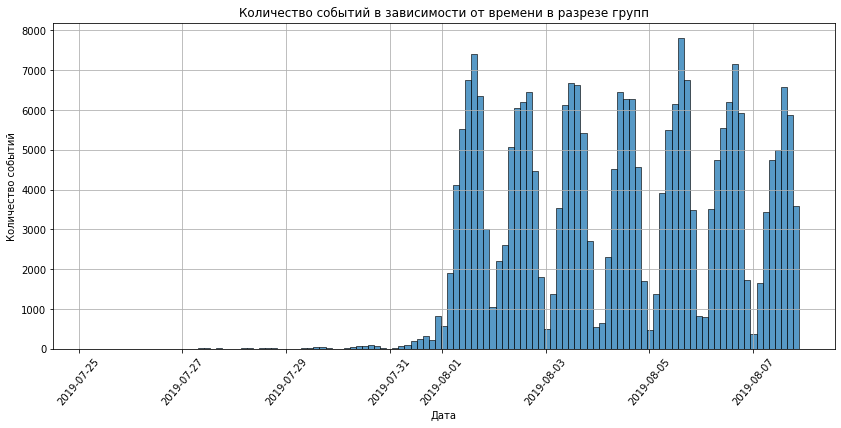

In [18]:
#выведем столбчатую диаграмму для наглядности
plt.figure(figsize=(14, 6))
sns.histplot(data=logs, x='timestamp')
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation=50)
plt.grid(which='major')
plt.show()

Определим, с какого момента данные полные и отбросим более старые

По диаграмме видно, что до 1 августа количество событий не достигает и 1000, зато уже 1 августа превышают 70000, поэтому данные до 1 августа можно отбросить

In [19]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_name     243713 non-null  object        
 1   device_id      243713 non-null  int64         
 2   timestamp      243713 non-null  datetime64[ns]
 3   experiment_id  243713 non-null  int64         
 4   date           243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


In [20]:
logs_new = logs.query('date > "2019-07-31"')
logs_new.head()

,event_name,device_id,timestamp,experiment_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


На самом деле мы располагаем данными за 7 дней (с 1 по 7 август включительно).

**3.5 Рассмотрим количество событий и пользователей, которых мы потеряли, отбросив старые данные**

In [21]:
#посчитаем события
logs_old = logs.query('date <= "2019-07-31"')
len(logs_old['event_name'])

2826

In [35]:
event_old_share = round(len(logs_old['event_name']) / len(logs['event_name']) * 100, 2)
event_old_share

1.16

In [31]:
device_old = logs['device_id'].nunique() - logs_new['device_id'].nunique()
device_old

17

In [36]:
device_old_share = round(device_old / logs['device_id'].nunique() * 100, 2)
device_old_share

0.23

Отбросив старые данные, мы потеряли всего 2826 (1.16%) событий и 17 (0.23%) пользователей. По сравнению с оставшимися, количество незначительно.

**3.6 Проверим, что у нас есть пользователи из всех трёх экспериментальных групп**

In [37]:
logs_new['experiment_id'].value_counts()

248    84563
246    79302
247    77022
Name: experiment_id, dtype: int64

У нас есть пользователи из всех трех экспериментальных групп, в каждой группе примерно одинаковое количество событий.

**Вывод:** в ходе изучения и проверки данных мы посчитали количество событий и пользователей и отбросили данные ранее 1 августа 2019. Данные с 1 по 7 августа 2019 готовы для дальнейшего изучения. 

### Изучение воронки событий

**4.1 Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте**

In [38]:
#выведем список уникальных событий
logs_new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

В логе 5 видов уникальных событий, они включают в себя просмотр главной страницы (117328), просмотр предложений (46333), просмотр корзины (42303), просмотр страницы успешной оплаты (33918), просмотр урока (1005). 

**4.2 Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей и посчитаем долю пользователей, которые хоть раз совершали событие**

In [39]:
users_events = logs_new.pivot_table(index='event_name',values='device_id',aggfunc='nunique').sort_values(by = 'device_id', ascending = False)
users_events['share'] = round(users_events / logs_new.device_id.nunique() * 100, 2)
users_events

,device_id,share
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


98% пользователей посещают главную страницу, 60% пользователей посещают страницу с предложениями, 49% пользователей посащают корзину, 46% пользователей посущают страницу оплаты, 11% пользователей посещают страницу обучения.

**4.3 Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?**

Выстраивается следующая цепочка:  
пользователь посещает главную страницу → затем страницу с предложениями → корзину → страницу оплаты.  
Обучение в данную цепочку не вписывается. Скорее всего, страница обучения появляется после регистрации и ее можно пропустить, поэтому ее посещало так мало пользователей. 

**4.4 По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)**

Для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [40]:
#создадим срез и сгруппируем данные
users_share = logs_new.query('event_name != "Tutorial"').groupby('event_name').agg({'device_id': 'nunique'}) \
                    .sort_values(by='device_id', ascending=False).reset_index()
users_share['share'] = round(100 + users_share['device_id'].pct_change() * 100, 2) #рассчитаем процентное соотношение
users_share

,event_name,device_id,share
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.30
3,PaymentScreenSuccessful,3539,94.78


От общего числа пользователей на первом шаге до второго доходит 61%, от второго до третьего - 81% и от третьего до четвертого - 94%.  
Больше всего пользователей (около 38%) теряется на втором шаге - при переходе с главной страницы на страницу с предложениями.

**4.5 Рассчитаем, какая доля пользователей доходит от первого события до оплаты**

In [41]:
users_share['total_share'] = round(users_share['device_id'] / users_share['device_id'][0] * 100, 2)
users_share

,event_name,device_id,share,total_share
0,MainScreenAppear,7419,NaN,100.00
1,OffersScreenAppear,4593,61.91,61.91
2,CartScreenAppear,3734,81.30,50.33
3,PaymentScreenSuccessful,3539,94.78,47.70


От первого события до оплаты доходит 47,7% пользователей. 

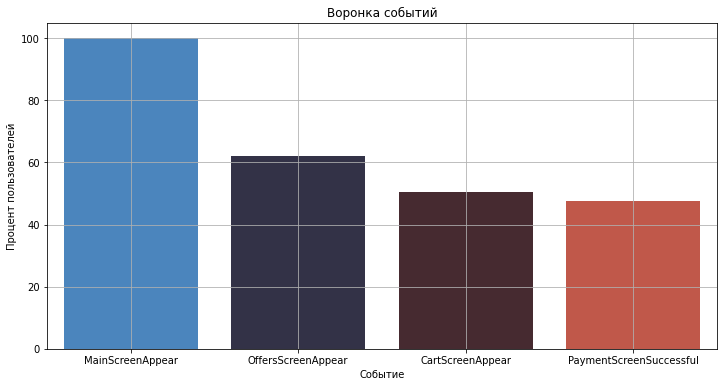

In [46]:
plt.figure(figsize=(12, 6)) #выведем столбчатую диаграмму для наглядности
sns.barplot(data=users_share, x='event_name', y='total_share', palette='icefire')
plt.title('Воронка событий')
plt.ylabel('Процент пользователей')
plt.xlabel('Событие')
plt.grid(which='major')
plt.show()

### Изучение результатов эксперимента

**5.1 Рассчитаем количество пользователей в каждой экспериментальной группе**

In [48]:
groups = logs_new.groupby('experiment_id')['device_id'].nunique()
groups

experiment_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

In [59]:
groups_share = round(logs_new.groupby('experiment_id')['device_id'].nunique() / logs_new['device_id'].nunique() * 100, 2)
groups_share

experiment_id
246    32.97
247    33.36
248    33.67
Name: device_id, dtype: float64

В группе 246 - 2484 (32.9%) пользователя, в 247 - 2513 (33.3%) пользователя, в 248 - 2537 (33.6%) пользователя.  
По экспериментальным группам пользователи распределены корректно, тест построен хорошо, разница в количестве меньше 1% и несущественна.


**5.2 Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247**

**Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие**

In [ ]:
events_and_users = logs_new[logs_new['experiment_id'] != 248].pivot_table(index=logs_new['event_name'], columns=logs_new['experiment_id'], aggfunc={'count', 'nunique'})['device_id']
events_and_users.columns = ['events_246', 'events_247', 'users_246', 'users_247']
events_and_users['events_246_247'] = events_and_users['events_246'] + events_and_users['events_247']
events_and_users['users_246_247'] = events_and_users['users_246'] + events_and_users['users_247']
events_and_users.sort_values(by='events_246', ascending=False)

Нулевая гипотеза: доли по событиям между группами равны.  
Альтернативная гипотеза: доли по событиям между группами различаются.  

Для проверки гипотез используем z-test для поиска статистически значимого различия.

In [ ]:
#функция для проверки гипотез
def z_test(group_a, group_b, event, alpha):
    group_users = np.array([logs_new.query('event_name == @event and experiment_id == @group_a').device_id.nunique(),
                           logs_new.query('event_name == @event and experiment_id == @group_b').device_id.nunique()])
    total_users = np.array([logs_new.query('experiment_id == @group_a').device_id.nunique(),
                           logs_new.query('experiment_id == @group_b').device_id.nunique()])
        #пропорция в первой группе:
    p1 = group_users[0]/total_users[0]

    #пропорция во второй группе:
    p2 = group_users[1]/total_users[1]

    #пропорция в комбинированном датасете:
    p_combined = (group_users[0] + group_users[1]) / (total_users[0] + total_users[1])

    #разница пропорций в датасетах
    difference = p1 - p2 

    #считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / total_users[0] + 1 / total_users[1])
    )

    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)    
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [ ]:
#критический уровень статистической значимости
alpha = 0.05  

Сравним группы 246 и 247

In [ ]:
group_a = 246
group_b = 247

print('\033[1m' + 'MainScreenAppear:' + '\033[0m')
event = 'MainScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'OffersScreenAppear:' + '\033[0m')
event = 'OffersScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'CartScreenAppear:' + '\033[0m')
event = 'CartScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'PaymentScreenSuccessful:' + '\033[0m')
event = 'PaymentScreenSuccessful'
z_test(group_a, group_b, event, alpha)

Самое популяерное событие, как ипредполагалось, - посещение пользователем главной страницы. Разбиение на группы работает корректно. Доли по событиям между группами равны.

**5.4 Аналогично поступим с группой с изменённым шрифтом**

Сравним результаты с каждой из контрольных групп в отдельности по каждому событию

Сравним группы 246 (контрольную) и 248 (экспериментальную)

In [ ]:
group_a = 246
group_b = 248

print('\033[1m' + 'MainScreenAppear:' + '\033[0m')
event = 'MainScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'OffersScreenAppear:' + '\033[0m')
event = 'OffersScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'CartScreenAppear:' + '\033[0m')
event = 'CartScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'PaymentScreenSuccessful:' + '\033[0m')
event = 'PaymentScreenSuccessful'
z_test(group_a, group_b, event, alpha)

Доли по событиям между группами равны, нулевую гипотезу не отвергаем.

Сравним группы 247 (контрольную) и 248 (экспериментальную)

In [ ]:
group_a = 247
group_b = 248

print('\033[1m' + 'MainScreenAppear:' + '\033[0m')
event = 'MainScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'OffersScreenAppear:' + '\033[0m')
event = 'OffersScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'CartScreenAppear:' + '\033[0m')
event = 'CartScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'PaymentScreenSuccessful:' + '\033[0m')
event = 'PaymentScreenSuccessful'
z_test(group_a, group_b, event, alpha)

Доли по событиям между группами равны, нулевую гипотезу не отвергаем.

**Сравним результаты с объединённой контрольной группой**

In [ ]:
group_a = [246, 247]
group_b = 248

print('\033[1m' + 'MainScreenAppear:' + '\033[0m')
event = 'MainScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'OffersScreenAppear:' + '\033[0m')
event = 'OffersScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'CartScreenAppear:' + '\033[0m')
event = 'CartScreenAppear'
z_test(group_a, group_b, event, alpha)

print('\033[1m' + 'PaymentScreenSuccessful:' + '\033[0m')
event = 'PaymentScreenSuccessful'
z_test(group_a, group_b, event, alpha)

**Вывод:** по итогам 16 проведенных тестов, нулевая гипотеза ни разу не была отвергнута, следовательно, доли по событиям между групп равны, а изменение шрифтов никак не повлияло на конверсию.

**5.5 Уровень значимости при проверке статистических гипотез**

**Какой уровень значимости был выбран при проверке статистических гипотез?**

При проверке гипотез был выбран уровень статистической значимости 0.05. Мы провели 16 проверок статистических гипотез, статистически значимой разницы между группами во всех тестах не выявлено.

**При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить?**

При увеличении уровня статистической значимости растет вероятность ошибки первого рода - можно ошибочно отклонить нулевую гипотезу при условии, что она верна. При уровне статистической значимости 0.1 каждый десятый раз можно получать ложный результат.  
В данном случае следует вместо 0.1 использовать метод Бонферрони или метод Шидака. Уровень статистической значимости будет ниже, а точность будет выше, и ни одна из нулевых гипотез не будет отвергнута (так же, как и в нашем случае), поэтому менять уровень статистической значимости и повторять тесты нецелесообразно.

### Общий вывод

Нами было проведено исследование поведения пользователей мобильного приложения стартапа, который продаёт продукты питания.  
В ходе исследования были отсечены данные за первую неделю, т.к. не несли практической пользы. Дальнейший анализ строился на основе данных за вторую неделю.  
Мы выяснили, что 98% пользователей посещают главную страницу, 60% пользователей посещают страницу с предложениями, 49% пользователей посащают корзину, 46% пользователей посущают страницу оплаты, 11% пользователей посещают страницу обучения. Большинство пользователей пропускает обучение.  
От общего числа пользователей на первом шаге до второго доходит 61%, от второго до третьего - 81% и от третьего до четвертого - 94%. Больше всего пользователей (около 38%) теряется на втором шаге - при переходе с главной страницы на страницу с предложениями. От первого события до оплаты доходит 47,7% пользователей.  
Также был проведен A/A/B-тест.  
Статистически значимых различий между двумя контрольными группами не найдено, пользователи распределены по группам корректно. Также статистически значимых различий не обнаружено и между контрольными и тестовой группами. Изменение шрифтов никак не влияет на конверсию.
Исходя из того, что мы отсекли данные за первую неделю, можно провести повторные тесты после дополнительного сбора данных, например, еще через неделю, но результат вряд ли изменится. 